### connect to drive and show the mfccs of each language.

In [25]:
from google.colab import drive
drive.mount('/content/drive') #for who is reviewing this notebook, we have sample datasets in GitHub, feel free to try it.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
!pip install pydub

In [27]:
!pip install librosa

In [29]:
audio_path = '/content/drive/MyDrive/BA865_Group_3/dataset'
#lang_folder = ('Arabic', 'Chinese', 'English', 'French', 'Germany', 'Japanese', 'Russian', 'Spanish', 'Thai') this is the lable we have as folder name

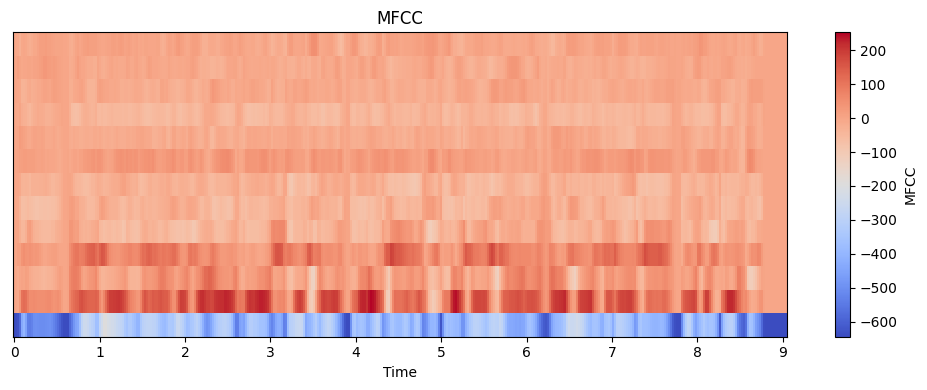

In [28]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

sample_audio = '/content/drive/MyDrive/BA865_Group_3/dataset/English/common_voice_en_38220472.mp3'# change this path by using the file we upload in github
y, sr = librosa.load(sample_audio)

mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(label='MFCC')
plt.title('MFCC')
plt.tight_layout()
plt.show()

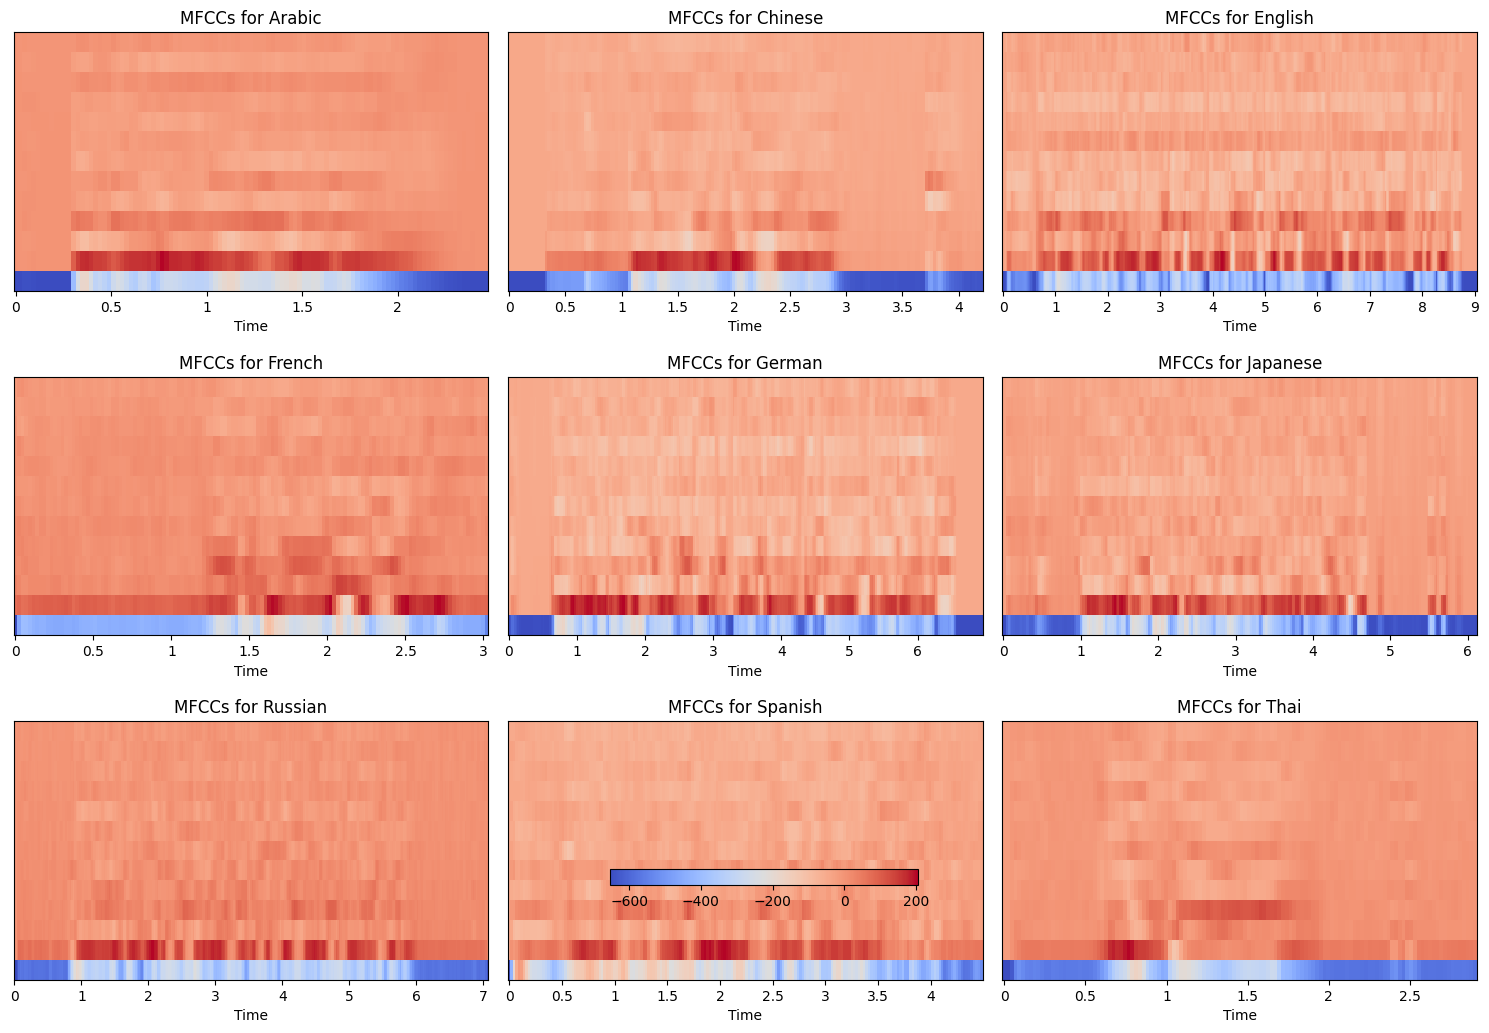

In [33]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def extract_and_plot_mfccs(audio_path, language, ax):
    y, sr = librosa.load(audio_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
    ax.set_title(f'MFCCs for {language}')
    return img

fig, axes = plt.subplots(3, 3, figsize=(15, 10))

languages = ['Arabic', 'Chinese', 'English', 'French', 'German', 'Japanese', 'Russian', 'Spanish', 'Thai']
images = []
#draw each mfcc plot to check the unique feature for each kind of languages
for i, language in enumerate(languages):
    audio_dir = f'/content/drive/MyDrive/BA865_Group_3/dataset/{language}'
    audio_files = os.listdir(audio_dir)
    audio_path = os.path.join(audio_dir, audio_files[0])
    ax = axes[i//3, i%3]
    img = extract_and_plot_mfccs(audio_path, language, ax)
    images.append(img)

fig.colorbar(images[0], ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
plt.tight_layout()
plt.show()

### features for model

In [ ]:
learning_rate = 0.001
epochs = 10
batch_size = 32
model_name = 'CNN'

### preprocess


In [34]:
!pip install h5py

In [35]:
import os
import librosa
import numpy as np
import h5py
import tensorflow as tf
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')

In [36]:
def process_audio(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=None)
        audio = librosa.util.normalize(audio)
        audio_trimmed, _ = librosa.effects.trim(audio, top_db=30, frame_length=2048, hop_length=512)

        mfccs = librosa.feature.mfcc(y=audio_trimmed, sr=sr, n_mfcc=13)

        max_len = max(mfccs.shape[1], 873)
        padded_mfccs = np.pad(mfccs, ((0, 0), (0, max_len - mfccs.shape[1])), mode='constant')

        mfccs_tensor = tf.convert_to_tensor(padded_mfccs, dtype=tf.float32)

        label = os.path.basename(file_path)

        return {'mfccs': mfccs_tensor, 'label': label}

    except Exception as e:
        print(f"Failed to process {file_path}: {str(e)}")
        return {}

def process_audio_parallel(file_paths):
    with Pool() as pool:
        results = pool.map(process_audio, file_paths)
    return results


def batch_audio_processor(base_path, output_file):
    file_paths = []
    labels = []
    for language in os.listdir(base_path):
        lang_path = os.path.join(base_path, language)
        if os.path.isdir(lang_path):
            for audio_file in os.listdir(lang_path):
                if audio_file.endswith('.mp3'):
                    file_paths.append(os.path.join(lang_path, audio_file))
                    labels.append(language)
    results = process_audio_parallel(file_paths)

    max_len = max(result['mfccs'].shape[1] for result in results if 'mfccs' in result)

    mfccs_list = []
    for result in results:
        if 'mfccs' in result:
            mfccs = result['mfccs']
            padded_mfccs = tf.pad(mfccs, [[0, 0], [0, max_len - mfccs.shape[1]]])
            mfccs_list.append(padded_mfccs)

    stacked_mfccs = tf.stack(mfccs_list)

    with h5py.File(output_file, 'w') as h5f:
        h5f.create_dataset('mfccs', data=stacked_mfccs.numpy())
        h5f.create_dataset('labels', data=labels)
#padding the mfccs, we will explain it in report in detail
base_path = '/content/drive/MyDrive/BA865_Group_3/dataset'
output_file = '/content/drive/MyDrive/BA865_Group_3/dataset/mfccs_and_labels.h5'
batch_audio_processor(base_path, output_file)

In [37]:
with h5py.File('/content/drive/MyDrive/BA865_Group_3/dataset/mfccs_and_labels.h5', 'r') as h5f:
    mfccs_dataset = h5f['mfccs']
    labels_dataset = h5f['labels']

    mfccs = np.array(mfccs_dataset)
    labels = np.array(labels_dataset)

import tensorflow as tf
mfccs_tensor = tf.convert_to_tensor(mfccs, dtype=tf.float32)

### Models

CNN

In [40]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical

def decode_if_bytes(text):
    if isinstance(text, bytes):
        return text.decode('utf-8')
    return text

labels = [decode_if_bytes(label) for label in labels]

X_train, X_test, y_train, y_test = train_test_split(mfccs, labels, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_one_hot = to_categorical(y_train_encoded, num_classes=9)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=9)

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(9, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2)

test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
print('CNN Test accuracy:', test_acc)


Epoch 1/10
18/18 [==============================] - 6s 279ms/step - loss: 16.6367 - accuracy: 0.1545 - val_loss: 2.1521 - val_accuracy: 0.1597
Epoch 2/10
18/18 [==============================] - 6s 327ms/step - loss: 2.0082 - accuracy: 0.3194 - val_loss: 2.0559 - val_accuracy: 0.2014
Epoch 3/10
18/18 [==============================] - 6s 332ms/step - loss: 1.3974 - accuracy: 0.5312 - val_loss: 1.9639 - val_accuracy: 0.3750
Epoch 4/10
18/18 [==============================] - 5s 296ms/step - loss: 0.6023 - accuracy: 0.8021 - val_loss: 1.9369 - val_accuracy: 0.4653
Epoch 5/10
18/18 [==============================] - 7s 380ms/step - loss: 0.2286 - accuracy: 0.9375 - val_loss: 2.3499 - val_accuracy: 0.4583
Epoch 6/10
18/18 [==============================] - 5s 276ms/step - loss: 0.0787 - accuracy: 0.9844 - val_loss: 2.5283 - val_accuracy: 0.5139
Epoch 7/10
18/18 [==============================] - 6s 328ms/step - loss: 0.0419 - accuracy: 0.9965 - val_loss: 2.9053 - val_accuracy: 0.4236
Epoch

LSTM

In [41]:
from tensorflow.keras.layers import LSTM

lstm_model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(9, activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2)

test_loss, test_acc = lstm_model.evaluate(X_test, y_test_one_hot)
print('LSTM Test accuracy:', test_acc)

Epoch 1/10
18/18 [==============================] - 7s 145ms/step - loss: 2.1209 - accuracy: 0.2014 - val_loss: 2.0271 - val_accuracy: 0.2500
Epoch 2/10
18/18 [==============================] - 1s 53ms/step - loss: 1.7639 - accuracy: 0.3941 - val_loss: 1.8013 - val_accuracy: 0.3403
Epoch 3/10
18/18 [==============================] - 1s 48ms/step - loss: 1.3382 - accuracy: 0.5903 - val_loss: 1.6424 - val_accuracy: 0.4097
Epoch 4/10
18/18 [==============================] - 1s 53ms/step - loss: 0.9086 - accuracy: 0.7865 - val_loss: 1.6714 - val_accuracy: 0.4097
Epoch 5/10
18/18 [==============================] - 1s 53ms/step - loss: 0.5844 - accuracy: 0.8698 - val_loss: 1.8380 - val_accuracy: 0.3681
Epoch 6/10
18/18 [==============================] - 1s 52ms/step - loss: 0.4539 - accuracy: 0.8819 - val_loss: 1.8682 - val_accuracy: 0.3958
Epoch 7/10
18/18 [==============================] - 1s 47ms/step - loss: 0.3617 - accuracy: 0.8924 - val_loss: 1.9406 - val_accuracy: 0.3750
Epoch 8/10
1

CRNN

In [42]:
from tensorflow.keras.layers import LSTM, TimeDistributed

crnn_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    TimeDistributed(Flatten()),

    LSTM(128, return_sequences=True),
    LSTM(64, return_sequences=False),


    Dense(64, activation='relu'),
    Dense(9, activation='softmax')
])

crnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
crnn_model.fit(X_train, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2)

test_loss, test_acc = crnn_model.evaluate(X_test, y_test_one_hot)
print('CRNN Test accuracy:', test_acc)


Epoch 1/10
18/18 [==============================] - 13s 417ms/step - loss: 2.1710 - accuracy: 0.1892 - val_loss: 2.1479 - val_accuracy: 0.1806
Epoch 2/10
18/18 [==============================] - 10s 586ms/step - loss: 2.1004 - accuracy: 0.2378 - val_loss: 2.0847 - val_accuracy: 0.1944
Epoch 3/10
18/18 [==============================] - 7s 380ms/step - loss: 2.0452 - accuracy: 0.2396 - val_loss: 2.0189 - val_accuracy: 0.2014
Epoch 4/10
18/18 [==============================] - 8s 468ms/step - loss: 2.0086 - accuracy: 0.2500 - val_loss: 2.0045 - val_accuracy: 0.2222
Epoch 5/10
18/18 [==============================] - 7s 375ms/step - loss: 1.9810 - accuracy: 0.2431 - val_loss: 1.9450 - val_accuracy: 0.2847
Epoch 6/10
18/18 [==============================] - 8s 462ms/step - loss: 1.9360 - accuracy: 0.2986 - val_loss: 1.9234 - val_accuracy: 0.2708
Epoch 7/10
18/18 [==============================] - 8s 427ms/step - loss: 1.9128 - accuracy: 0.2951 - val_loss: 1.9106 - val_accuracy: 0.2500
Epoc

transfer with pretrain model VGG16

In [44]:
#transfer with VGG16
import numpy as np
import h5py
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical



dataset_path = '/content/drive/MyDrive/BA865_Group_3/dataset/mfccs_and_labels.h5'
with h5py.File(dataset_path, 'r') as h5f:
    mfccs = h5f['mfccs'][:]
    labels = h5f['labels'][:]

labels = [label.decode('utf-8') for label in labels]

X_train, X_test, y_train, y_test = train_test_split(mfccs, labels, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_one_hot = to_categorical(y_train_encoded, num_classes=9)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=9)

pad_height = max(32 - X_train.shape[1], 0)
pad_width = max(32 - X_train.shape[2], 0)


from tensorflow.image import resize

X_train_padded = np.pad(X_train, ((0, 0), (0, pad_height), (0, pad_width)), mode='constant')
X_test_padded = np.pad(X_test, ((0, 0), (0, pad_height), (0, pad_width)), mode='constant')

X_train_rgb = np.repeat(X_train_padded[..., np.newaxis], 3, axis=-1)
X_train_rgb_resized = np.array([resize(X_train_rgb[i], size=(32, 32)) for i in range(X_train_rgb.shape[0])])
X_test_rgb = np.repeat(X_test_padded[..., np.newaxis], 3, axis=-1)
X_test_rgb_resized = np.array([resize(X_test_rgb[i], size=(32, 32)) for i in range(X_test_rgb.shape[0])])

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(9, activation='softmax')(x)

transfer_model = Model(inputs=base_model.input, outputs=predictions)

transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

transfer_model.fit(X_train_rgb_resized, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2)

test_loss, test_acc = transfer_model.evaluate(X_test_rgb_resized, y_test_one_hot)
print('VGG16 Transfor Test accuracy:', test_acc)

Epoch 1/10
18/18 [==============================] - 10s 494ms/step - loss: 8.3009 - accuracy: 0.1736 - val_loss: 5.3072 - val_accuracy: 0.2153
Epoch 2/10
18/18 [==============================] - 8s 462ms/step - loss: 3.6409 - accuracy: 0.2882 - val_loss: 2.8756 - val_accuracy: 0.3681
Epoch 3/10
18/18 [==============================] - 9s 490ms/step - loss: 2.5585 - accuracy: 0.3681 - val_loss: 3.1111 - val_accuracy: 0.3125
Epoch 4/10
18/18 [==============================] - 7s 391ms/step - loss: 2.2789 - accuracy: 0.4167 - val_loss: 2.5553 - val_accuracy: 0.3542
Epoch 5/10
18/18 [==============================] - 10s 585ms/step - loss: 1.8657 - accuracy: 0.4601 - val_loss: 2.5218 - val_accuracy: 0.3333
Epoch 6/10
18/18 [==============================] - 9s 521ms/step - loss: 1.6984 - accuracy: 0.4757 - val_loss: 2.7914 - val_accuracy: 0.3333
Epoch 7/10
18/18 [==============================] - 7s 391ms/step - loss: 1.7383 - accuracy: 0.4705 - val_loss: 2.2201 - val_accuracy: 0.3542
Epoc

### WandB

In [45]:
if enable_wandb:
  !pip install wandb -qU
  import wandb
  wandb.login()

In [49]:
import wandb
from wandb.keras import WandbCallback

enable_wandb = True

#Parameters
learning_rate = 0.001
epochs = 10
batch_size = 32
model_name = 'model_example'


#LSTM
if enable_wandb:
    wandb.init(project='865Project LSTM',
                config={'learning_rate': learning_rate,
                        'epochs': epochs,
                        'batch_size': batch_size,
                        'architecture': model_name})
    lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    lstm_model.fit(X_train, y_train_one_hot,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    callbacks=[WandbCallback()])

    test_loss, test_acc = lstm_model.evaluate(X_test, y_test_one_hot)
    print('LSTM Test accuracy:', test_acc)
    wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
    wandb.finish()

#CRNN
if enable_wandb:
    wandb.init(project='865Project CRNN',
                config={'learning_rate': learning_rate,
                        'epochs': epochs,
                        'batch_size': batch_size,
                        'architecture': model_name})
    crnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    crnn_model.fit(X_train, y_train_one_hot,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    callbacks=[WandbCallback()])

    test_loss, test_acc = crnn_model.evaluate(X_test, y_test_one_hot)
    print('CRNN Test accuracy:', test_acc)
    wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
    wandb.finish()

#CNN
if enable_wandb:
  wandb.init(project='865Project CNN',
            config={'learning_rate': learning_rate,
                    'epochs': epochs,
                    'batch_size': batch_size,
                    'architecture': model_name})
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  model.fit(X_train, y_train_one_hot,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[WandbCallback()])

  test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
  print('CNN Test accuracy:', test_acc)
  wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
  wandb.finish()


Epoch 1/10
18/18 [==============================] - ETA: 0s - loss: 0.1014 - accuracy: 0.9740

wandb: Adding directory to artifact (/content/wandb/run-20240426_010831-rkuqwxva/files/model-best)... Done. 0.0s


18/18 [==============================] - 14s 634ms/step - loss: 0.1014 - accuracy: 0.9740 - val_loss: 2.5252 - val_accuracy: 0.3472
Epoch 2/10
18/18 [==============================] - ETA: 0s - loss: 0.1032 - accuracy: 0.9757

wandb: Adding directory to artifact (/content/wandb/run-20240426_010831-rkuqwxva/files/model-best)... Done. 0.1s


18/18 [==============================] - 9s 514ms/step - loss: 0.1032 - accuracy: 0.9757 - val_loss: 2.3959 - val_accuracy: 0.3819
Epoch 3/10
18/18 [==============================] - 2s 91ms/step - loss: 0.0833 - accuracy: 0.9774 - val_loss: 2.9201 - val_accuracy: 0.3333
Epoch 4/10
18/18 [==============================] - 1s 72ms/step - loss: 0.0447 - accuracy: 0.9931 - val_loss: 2.9151 - val_accuracy: 0.3819
Epoch 5/10
18/18 [==============================] - 1s 58ms/step - loss: 0.0366 - accuracy: 0.9913 - val_loss: 2.8340 - val_accuracy: 0.3681
Epoch 6/10
18/18 [==============================] - 1s 54ms/step - loss: 0.0261 - accuracy: 0.9931 - val_loss: 2.8888 - val_accuracy: 0.3750
Epoch 7/10
18/18 [==============================] - 1s 52ms/step - loss: 0.0144 - accuracy: 0.9983 - val_loss: 2.8190 - val_accuracy: 0.3472
Epoch 8/10
18/18 [==============================] - 1s 59ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 3.0246 - val_accuracy: 0.3542
Epoch 9/10
18/18 [=====

accuracy,▁▁▂▆▆▆████
epoch,▁▂▃▃▄▅▆▆▇█
loss,██▇▄▃▃▂▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▃▇▁▇▅▆▃▄█▇
val_loss,▂▁▇▇▆▆▆█▇▆
accuracy,1.0
best_epoch,1
best_val_loss,2.39591
epoch,9


Epoch 1/10
18/18 [==============================] - ETA: 0s - loss: 1.9004 - accuracy: 0.2517

wandb: Adding directory to artifact (/content/wandb/run-20240426_010922-1ju1y38m/files/model-best)... Done. 0.9s


18/18 [==============================] - 23s 1s/step - loss: 1.9004 - accuracy: 0.2517 - val_loss: 1.8898 - val_accuracy: 0.2083
Epoch 2/10
18/18 [==============================] - 9s 523ms/step - loss: 1.8475 - accuracy: 0.2830 - val_loss: 1.9005 - val_accuracy: 0.2431
Epoch 3/10
18/18 [==============================] - ETA: 0s - loss: 1.8374 - accuracy: 0.2847

wandb: Adding directory to artifact (/content/wandb/run-20240426_010922-1ju1y38m/files/model-best)... Done. 0.6s


18/18 [==============================] - 17s 987ms/step - loss: 1.8374 - accuracy: 0.2847 - val_loss: 1.8420 - val_accuracy: 0.3264
Epoch 4/10
18/18 [==============================] - 9s 476ms/step - loss: 1.8342 - accuracy: 0.2865 - val_loss: 1.9358 - val_accuracy: 0.1875
Epoch 5/10
18/18 [==============================] - 7s 367ms/step - loss: 1.8817 - accuracy: 0.2865 - val_loss: 1.8952 - val_accuracy: 0.2431
Epoch 6/10
18/18 [==============================] - 13s 719ms/step - loss: 1.9018 - accuracy: 0.2986 - val_loss: 1.9601 - val_accuracy: 0.1944
Epoch 7/10
18/18 [==============================] - 11s 571ms/step - loss: 1.8886 - accuracy: 0.2656 - val_loss: 1.9346 - val_accuracy: 0.2014
Epoch 8/10
18/18 [==============================] - ETA: 0s - loss: 1.8599 - accuracy: 0.2830

wandb: Adding directory to artifact (/content/wandb/run-20240426_010922-1ju1y38m/files/model-best)... Done. 0.6s


18/18 [==============================] - 17s 955ms/step - loss: 1.8599 - accuracy: 0.2830 - val_loss: 1.8148 - val_accuracy: 0.2917
Epoch 9/10
18/18 [==============================] - 8s 464ms/step - loss: 1.8407 - accuracy: 0.2812 - val_loss: 1.8699 - val_accuracy: 0.2986
Epoch 10/10
6/6 [==============================] - 1s 84ms/step - loss: 1.7531 - accuracy: 0.2556
CRNN Test accuracy: 0.25555557012557983


accuracy,▁▆▆▆▆█▃▆▅▆
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▅▅▇█▇▆▅▁
test_accuracy,▁
test_loss,▁
val_accuracy,▂▄█▁▄▁▂▆▇▃
val_loss,▅▅▂▇▅█▇▁▄▄
accuracy,0.28646
best_epoch,7
best_val_loss,1.81478
epoch,9


Epoch 1/10
18/18 [==============================] - ETA: 0s - loss: 0.0537 - accuracy: 0.9844

wandb: Adding directory to artifact (/content/wandb/run-20240426_011131-3oka5vay/files/model-best)... Done. 0.1s


18/18 [==============================] - 8s 359ms/step - loss: 0.0537 - accuracy: 0.9844 - val_loss: 3.3430 - val_accuracy: 0.5278
Epoch 2/10
18/18 [==============================] - ETA: 0s - loss: 0.0409 - accuracy: 0.9844

wandb: Adding directory to artifact (/content/wandb/run-20240426_011131-3oka5vay/files/model-best)... Done. 0.1s


18/18 [==============================] - 8s 430ms/step - loss: 0.0409 - accuracy: 0.9844 - val_loss: 3.1667 - val_accuracy: 0.4583
Epoch 3/10
18/18 [==============================] - 5s 267ms/step - loss: 0.0162 - accuracy: 0.9965 - val_loss: 3.4551 - val_accuracy: 0.5069
Epoch 4/10
18/18 [==============================] - 5s 266ms/step - loss: 0.0083 - accuracy: 0.9965 - val_loss: 4.0487 - val_accuracy: 0.5278
Epoch 5/10
18/18 [==============================] - 7s 384ms/step - loss: 0.0092 - accuracy: 0.9983 - val_loss: 3.6423 - val_accuracy: 0.4792
Epoch 6/10
18/18 [==============================] - 5s 263ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 3.5283 - val_accuracy: 0.5139
Epoch 7/10
18/18 [==============================] - 6s 316ms/step - loss: 1.4969e-04 - accuracy: 1.0000 - val_loss: 3.5982 - val_accuracy: 0.5347
Epoch 8/10
18/18 [==============================] - 6s 305ms/step - loss: 7.4877e-05 - accuracy: 1.0000 - val_loss: 3.6403 - val_accuracy: 0.5486
Epoch 9/1

accuracy,▁▁▆▆▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▃▂▂▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▆▁▄▆▂▅▆▇▇█
val_loss,▂▁▃█▅▄▄▅▅▅
accuracy,1.0
best_epoch,1
best_val_loss,3.16674
epoch,9


In [47]:
#VGG16
import wandb
from wandb.keras import WandbCallback

enable_wandb = True
if enable_wandb:
    wandb.login()
    wandb.init(project='865Project VGG16 Transfer',
               config={
                   'learning_rate': 0.001,
                   'epochs': 10,
                   'batch_size': 32,
                   'architecture': 'VGG16 Transfer'
               })


transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transfer_model.fit(X_train_rgb_resized, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2,
                   callbacks=[WandbCallback() if enable_wandb else None])


test_loss, test_acc = transfer_model.evaluate(X_test_rgb_resized, y_test_one_hot)
print('VGG16 Transfer Test accuracy:', test_acc)

if enable_wandb:
    wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
    wandb.finish()



Epoch 1/10
18/18 [==============================] - ETA: 0s - loss: 2.1691 - accuracy: 0.4340

wandb: Adding directory to artifact (/content/wandb/run-20240426_010141-11bweol2/files/model-best)... Done. 0.9s


18/18 [==============================] - 14s 734ms/step - loss: 2.1691 - accuracy: 0.4340 - val_loss: 2.3766 - val_accuracy: 0.3889
Epoch 2/10
18/18 [==============================] - ETA: 0s - loss: 1.5752 - accuracy: 0.5260

wandb: Adding directory to artifact (/content/wandb/run-20240426_010141-11bweol2/files/model-best)... Done. 0.6s


18/18 [==============================] - 11s 629ms/step - loss: 1.5752 - accuracy: 0.5260 - val_loss: 2.0209 - val_accuracy: 0.3750
Epoch 3/10
18/18 [==============================] - 9s 495ms/step - loss: 1.3957 - accuracy: 0.5729 - val_loss: 2.1058 - val_accuracy: 0.4931
Epoch 4/10
18/18 [==============================] - ETA: 0s - loss: 1.3987 - accuracy: 0.5729

wandb: Adding directory to artifact (/content/wandb/run-20240426_010141-11bweol2/files/model-best)... Done. 0.5s


18/18 [==============================] - 12s 701ms/step - loss: 1.3987 - accuracy: 0.5729 - val_loss: 1.7602 - val_accuracy: 0.4722
Epoch 5/10
18/18 [==============================] - 9s 485ms/step - loss: 1.1707 - accuracy: 0.5955 - val_loss: 1.9076 - val_accuracy: 0.4444
Epoch 6/10
18/18 [==============================] - 9s 517ms/step - loss: 1.3424 - accuracy: 0.5903 - val_loss: 2.3260 - val_accuracy: 0.3889
Epoch 7/10
18/18 [==============================] - 9s 517ms/step - loss: 1.2696 - accuracy: 0.5903 - val_loss: 1.8457 - val_accuracy: 0.4444
Epoch 8/10
18/18 [==============================] - 8s 479ms/step - loss: 1.1457 - accuracy: 0.6337 - val_loss: 1.9550 - val_accuracy: 0.4444
Epoch 9/10
18/18 [==============================] - 10s 543ms/step - loss: 0.9933 - accuracy: 0.6476 - val_loss: 1.9013 - val_accuracy: 0.4514
Epoch 10/10
6/6 [==============================] - 2s 290ms/step - loss: 2.1746 - accuracy: 0.4944
VGG16 Transfer Test accuracy: 0.49444442987442017


accuracy,▁▄▆▆▆▆▆███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▃▃▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▂▁█▇▅▂▅▅▆▁
val_loss,█▄▅▁▃▇▂▃▃▅
accuracy,0.64236
best_epoch,3
best_val_loss,1.76016
epoch,9


In [ ]:
#LSTM
from wandb.keras import WandbCallback
if enable_wandb:
  wandb.init(project = '865Project LSTM',
             config = {'learning_rate' : learning_rate,
                       'epochs' : epochs,
                       'batch_size' : batch_size,
                       'architecture': model_name})
  lstm_model.fit(X_train, y_train_one_hot,
              epochs=epochs,
              batch_size=batch_size,
              validation_split=0.2,
              callbacks=[WandbCallback()])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=batch_size, validation_split=0.2)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
18/18 [==============================] - ETA: 0s - loss: 0.0858 - accuracy: 0.9809

wandb: Adding directory to artifact (/content/wandb/run-20240425_145923-sdnbbuz8/files/model-best)... Done. 0.1s


18/18 [==============================] - 10s 571ms/step - loss: 0.0858 - accuracy: 0.9809 - val_loss: 2.4155 - val_accuracy: 0.3681
Epoch 2/10
18/18 [==============================] - 2s 115ms/step - loss: 0.0525 - accuracy: 0.9931 - val_loss: 2.4447 - val_accuracy: 0.3681
Epoch 3/10
18/18 [==============================] - 1s 62ms/step - loss: 0.0197 - accuracy: 1.0000 - val_loss: 2.4714 - val_accuracy: 0.3611
Epoch 4/10
18/18 [==============================] - 1s 57ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 2.5455 - val_accuracy: 0.3681
Epoch 5/10
18/18 [==============================] - 1s 59ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 2.5823 - val_accuracy: 0.3542
Epoch 6/10
18/18 [==============================] - 1s 60ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 2.6172 - val_accuracy: 0.3264
Epoch 7/10
18/18 [==============================] - 1s 56ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 2.6525 - val_accuracy: 0.3194
Epoch 8/10
18/18 [===

In [ ]:
#CNN
from wandb.keras import WandbCallback
if enable_wandb:
  wandb.init(project = '865Project CNN',
             config = {'learning_rate' : learning_rate,
                       'epochs' : epochs,
                       'batch_size' : batch_size,
                       'architecture': model_name})
  model.fit(X_train, y_train_one_hot,
              epochs=epochs,
              batch_size=batch_size,
              validation_split=0.2,
              callbacks=[WandbCallback()])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=batch_size, validation_split=0.2)

accuracy,▁▅████████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▂▂▁▁▁▁▁▁
val_accuracy,██▇█▆▂▁▂▂▂
val_loss,▁▂▂▄▅▆▇▇██
accuracy,1.0
best_epoch,0
best_val_loss,2.41548
epoch,9
loss,0.00219
val_accuracy,0.32639


Epoch 1/10
18/18 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

wandb: Adding directory to artifact (/content/wandb/run-20240425_150132-deletjm4/files/model-best)... Done. 0.1s


18/18 [==============================] - 8s 420ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 2.9935 - val_accuracy: 0.5139
Epoch 2/10
18/18 [==============================] - 7s 384ms/step - loss: 9.6401e-04 - accuracy: 1.0000 - val_loss: 3.0395 - val_accuracy: 0.5208
Epoch 3/10
18/18 [==============================] - 5s 283ms/step - loss: 7.7877e-04 - accuracy: 1.0000 - val_loss: 3.0923 - val_accuracy: 0.5139
Epoch 4/10
18/18 [==============================] - 5s 277ms/step - loss: 6.4621e-04 - accuracy: 1.0000 - val_loss: 3.1341 - val_accuracy: 0.5139
Epoch 5/10
18/18 [==============================] - 7s 392ms/step - loss: 5.4847e-04 - accuracy: 1.0000 - val_loss: 3.1515 - val_accuracy: 0.5139
Epoch 6/10
18/18 [==============================] - 5s 274ms/step - loss: 4.7252e-04 - accuracy: 1.0000 - val_loss: 3.1872 - val_accuracy: 0.5069
Epoch 7/10
18/18 [==============================] - 6s 340ms/step - loss: 4.1145e-04 - accuracy: 1.0000 - val_loss: 3.2171 - val_accuracy: 

In [ ]:
#CRNN
from wandb.keras import WandbCallback
if enable_wandb:
  wandb.init(project = '865Project CRNN',
             config = {'learning_rate' : learning_rate,
                       'epochs' : epochs,
                       'batch_size' : batch_size,
                       'architecture': model_name})
  crnn_model.fit(X_train, y_train_one_hot,
              epochs=epochs,
              batch_size=batch_size,
              validation_split=0.2,
              callbacks=[WandbCallback()])

crnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
crnn_model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/10
18/18 [==============================] - ETA: 0s - loss: 2.0487 - accuracy: 0.2083

wandb: Adding directory to artifact (/content/wandb/run-20240425_150746-gtg95i8v/files/model-best)... Done. 3.2s


18/18 [==============================] - 21s 1s/step - loss: 2.0487 - accuracy: 0.2083 - val_loss: 2.0403 - val_accuracy: 0.1250
Epoch 2/10
18/18 [==============================] - 12s 684ms/step - loss: 2.0734 - accuracy: 0.1788 - val_loss: 2.0437 - val_accuracy: 0.2083
Epoch 3/10
18/18 [==============================] - 8s 443ms/step - loss: 2.0891 - accuracy: 0.1875 - val_loss: 2.0917 - val_accuracy: 0.1944
Epoch 4/10
18/18 [==============================] - ETA: 0s - loss: 2.0098 - accuracy: 0.2222

wandb: Adding directory to artifact (/content/wandb/run-20240425_150746-gtg95i8v/files/model-best)... Done. 0.6s


18/18 [==============================] - 17s 971ms/step - loss: 2.0098 - accuracy: 0.2222 - val_loss: 1.9928 - val_accuracy: 0.2292
Epoch 5/10
18/18 [==============================] - 7s 408ms/step - loss: 1.9837 - accuracy: 0.2205 - val_loss: 2.0043 - val_accuracy: 0.2222
Epoch 6/10
18/18 [==============================] - ETA: 0s - loss: 1.9749 - accuracy: 0.2222

wandb: Adding directory to artifact (/content/wandb/run-20240425_150746-gtg95i8v/files/model-best)... Done. 0.8s


18/18 [==============================] - 18s 1s/step - loss: 1.9749 - accuracy: 0.2222 - val_loss: 1.9685 - val_accuracy: 0.1875
Epoch 7/10
18/18 [==============================] - ETA: 0s - loss: 1.9948 - accuracy: 0.2101

wandb: Adding directory to artifact (/content/wandb/run-20240425_150746-gtg95i8v/files/model-best)... Done. 0.6s


18/18 [==============================] - 19s 1s/step - loss: 1.9948 - accuracy: 0.2101 - val_loss: 1.9378 - val_accuracy: 0.2292
Epoch 8/10
18/18 [==============================] - 7s 408ms/step - loss: 2.0029 - accuracy: 0.2326 - val_loss: 1.9887 - val_accuracy: 0.2014
Epoch 9/10
18/18 [==============================] - 9s 489ms/step - loss: 2.0213 - accuracy: 0.2031 - val_loss: 2.0513 - val_accuracy: 0.1250
Epoch 10/10
18/18 [==============================] - 8s 471ms/step - loss: 2.0242 - accuracy: 0.1910 - val_loss: 2.0127 - val_accuracy: 0.1806
Epoch 1/10
18/18 [==============================] - 25s 785ms/step - loss: 2.0092 - accuracy: 0.2205 - val_loss: 2.0317 - val_accuracy: 0.2014
Epoch 2/10
18/18 [==============================] - 14s 770ms/step - loss: 1.9738 - accuracy: 0.2240 - val_loss: 1.9722 - val_accuracy: 0.2569
Epoch 3/10
18/18 [==============================] - 9s 509ms/step - loss: 1.9719 - accuracy: 0.2378 - val_loss: 1.9769 - val_accuracy: 0.2222
Epoch 4/10
18/18

### input audio recorded into model and classify

In [57]:
from google.colab import files

uploaded = files.upload()
for filename in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=filename, length=len(uploaded[filename])))


Saving common_voice_en_38220472.mp3 to common_voice_en_38220472.mp3
User uploaded file "common_voice_en_38220472.mp3" with length 54261 bytes


In [58]:
file_path = next(iter(uploaded))
audio_data = process_audio(file_path)

In [59]:
if 'mfccs' in audio_data:
    prediction = model.predict(np.expand_dims(audio_data['mfccs'], axis=0))
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    print("Predicted Label:", predicted_label)
else:
    print("Failed to process prediction.")
#classify the audio by using the upload cell before

1/1 [==============================] - 0s 139ms/step
Predicted Label: ['English']
